In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) '
                '{ jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>',
                raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [1]:
import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mne.externals.h5io import read_hdf5, write_hdf5

from scipy.signal import detrend
from scipy.stats import trim_mean

from scipy.stats import kendalltau, pearsonr

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import mne
from mne.utils import _time_mask as freq_mask

from library.stats import compute_corr

from library.downloaders import get_single_trial_source_psd

from library.stats import compute_log_linear_fit

In [2]:
mne.utils.set_log_level('warning')

In [3]:
%reload_ext autoreload
%autoreload 2

### loading source data

In [6]:
# %run hcp_compute_subject.py --subject 100307 --s3 --downloaders \
#     "/home/ubuntu/github/swish/aws_scripts/library:downloaders.get_single_trial_source_psd" --keep_files \
#     --hcp_no_meg --hcp_no_anat

Elapsed time downloading hcp-openaccess from s3 00:00:00
could not get hcp-meg/100307/psds-r0-1-150-times.npy : it does not exist
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 100307
downloading only
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/call.txt
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/script.py
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/run_output.log
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/hcp_compute_subject.py
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/call.txt
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/run_time.json
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/report.html
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/done
uploading /mnt/hcp-meg/100307/download_only/2016-05-10_18-50-47/writt

/home/ubuntu/miniconda2/envs/swish/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [158]:
# %run hcp_compute_subject.py --subject 100307 --s3 --downloaders \
#     "/home/ubuntu/github/swish/aws_scripts/library:downloaders.get_psds_times" --keep_files \
#     --hcp_no_meg --hcp_no_anat

Elapsed time downloading hcp-openaccess from s3 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 100307
downloading only
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/call.txt
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/call.txt
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/run_output.log
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/run_time.json
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/hcp_compute_subject.py
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/script.py
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/report.html
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/done
uploading /mnt/hcp-meg/100307/download_only/2016-05-11_11-46-49/written_files.txt
Elapsed time uploading to s3 00:00:01
Elapsed time for runni

### get all file names and group by run

In [4]:
stc_files = dict(r0=list(), r1=list(), r2=list())
for fname in glob.glob('/mnt/hcp-meg/100307/*stc'):
    for pattern in get_single_trial_source_psd('100307')['key_list']:
        if glob.fnmatch.fnmatch(fname, '*' + pattern):
            if 'r1' in fname:
                key = 'r1'
            elif 'r2' in fname:
                key = 'r2'
            else:
                key = 'r0'
            stc_files[key].append(fname)

## compute grand average alpha

In [8]:
X = 0.
for ii, fnames in enumerate(sum(stc_files.values(), [])):
    stc = mne.read_source_estimate(fname)
    X += np.log10(stc.data)
stc._data = X
stc._data /= ii

## compute grand average 1/f

In [15]:
def stc_gen(stc_files):
    for ii, fnames in enumerate(sum(stc_files.values(), [])):
        stc = mne.read_source_estimate(fname)
        yield stc.data

coefs_, _, mse_, _ = compute_log_linear_fit(
    stc_gen(stc_files), freqs=np.linspace(0.001, 127, len(stc.times)), sfmin=0.1, sfmax=1.,
    log_fun=np.log10)

## compute label time courses for all runs

In [17]:
from library.workflows import get_brodmann_labels
written_files = get_brodmann_labels(spacing='oct5', subjects_dir='/home/ubuntu/freesurfer/subjects')

In [25]:
if not op.exists('/mnt/hcp-subjects'):
    os.mkdir('/mnt/hcp-subjects')

if not op.exists('/mnt/hcp-subjects/fsaverage'):
    os.symlink('/home/ubuntu/freesurfer/subjects/fsaverage',
               '/mnt/hcp-subjects/fsaverage')
[f for f in os.listdir('/mnt/hcp-subjects/fsaverage/label') if 'oct5' in f][:10]

['Brodmann-oct5.9-rh.label',
 'Brodmann-oct5.29-rh.label',
 'Brodmann-oct5.45-rh.label',
 'Brodmann-oct5.38-lh.label',
 'Brodmann-oct5.3-rh.label',
 'Brodmann-oct5.23-rh.label',
 'Brodmann-oct5.24-rh.label',
 'Brodmann-oct5.26-lh.label',
 'Brodmann-oct5.37-lh.label',
 'Brodmann-oct5.18-lh.label']

In [23]:
src_orig = mne.setup_source_space(subject='fsaverage', fname=None, spacing='oct5', add_dist=False,
                                  subjects_dir='/mnt/hcp-subjects')

In [101]:
label_tcs = list()
for ii, fname in enumerate(sum(stc_files.values(), [])):
    stc = mne.read_source_estimate(fname)
    stc.subject = '100307'
    stc = stc.to_original_src(src_orig, 'fsaverage', subjects_dir=hcp_subjects_dir)
    label_tcs.append(
        np.array(
            [stc.extract_label_time_course(label, src_orig, mode='mean')
             for label in labels]))

In [106]:
label_tcs = np.array(label_tcs)[:, :, 0, :]
print(label_tcs.shape)

(338, 82, 3815)


(-1.0, 2.0)

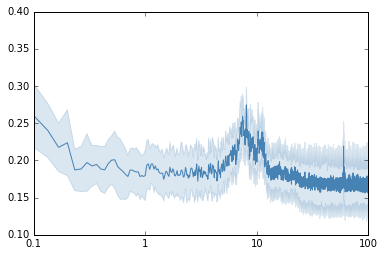

In [126]:
%matplotlib inline
freqs = np.linspace(0.001, 127, len(stc.times))
X = np.log10(label_tcs).std(0).T
X_mean = X.mean(1)
X_std = X.std(1)
plt.plot(np.log10(freqs), X_mean, color='steelblue');
plt.fill_between(np.log10(freqs), X_mean - X_std, X_mean + X_std, color='steelblue', alpha=0.2);
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 100]))

## compute grand average correlations on label time courses

In [6]:
from library.workflows import compute_source_outputs

In [ ]:
# %%bash
# python hcp_compute_subject.py --subject 100307 --fun_path \
%run hcp_compute_subject.py --subject 100307 --fun_path \
    "/home/ubuntu/github/swish/aws_scripts/library:workflows.compute_source_outputs" \
    --keep_files \
    --s3 \
    --hcp_no_anat \
    --hcp_no_meg \
    --hcp_run_inds 0 \
    --mkl_num_threads 4 \
    --fun_args --spacing oct5 --hcp_subjects_dir /mnt/hcp-subjects

In [188]:
out

['power-0-150-lh.stc',
 'power-0-150-rh.stc',
 'power-0-150-lh.stc',
 'power-0-150-rh.stc',
 'power-0-150-lh.stc',
 'power-0-150-rh.stc']

In [194]:
labels

[<Label  |  unknown, 'Brodmann-oct5.1-lh', lh : 42 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.1-rh', rh : 35 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.2-lh', lh : 52 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.2-rh', rh : 43 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.3-lh', lh : 37 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.3-rh', rh : 39 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.4-lh', lh : 83 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.4-rh', rh : 80 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.5-lh', lh : 21 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.5-rh', rh : 22 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.6-lh', lh : 77 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.6-rh', rh : 76 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.7-lh', lh : 75 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.7-rh', rh : 70 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.8-lh', lh : 26 vertices>,
 <Label  |  unknown, 'Brodmann-oct5.8-rh', rh : 32 vertices>,
 <Label 